In [1]:
import os
import os.path
import gc
import itertools
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

## Read Data

In [6]:
%%time
DATA_DIR = '../input/open-problems-multimodal'
train_tar = pd.read_hdf(f'{DATA_DIR}/train_cite_targets.h5')
train_tar_cols = train_tar.columns

CPU times: user 235 ms, sys: 84.6 ms, total: 320 ms
Wall time: 864 ms


In [7]:
train_tar = train_tar.values

In [8]:
%%time
DATA_DIR = '../input/msci-citeseq-mlp-tsvd'
train_inp = load_pickle(f'{DATA_DIR}/train_inp')

CPU times: user 60.4 ms, sys: 428 ms, total: 488 ms
Wall time: 2.54 s


In [9]:
train_inp = train_inp[:, :-7]

## Modeling

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

## Dataset & DataLoader

In [11]:
%%time
train_inp = torch.from_numpy(train_inp)
train_tar = torch.from_numpy(train_tar)

CPU times: user 28 µs, sys: 7 µs, total: 35 µs
Wall time: 37.9 µs


In [12]:
full_ds = TensorDataset(train_inp, train_tar)
train_sz = 56832
val_sz = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, 
                                [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

In [13]:
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### Define NN

In [14]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
#         self.linear1 = nn.Linear(663, 128*2)
        self.linear1 = nn.Linear(656, 128*4)
        self.bn1 = nn.BatchNorm1d(128*4)
        self.linear2 = nn.Linear(128*4, 128*4)
        self.bn2 = nn.BatchNorm1d(128*4)
        self.linear3 = nn.Linear(128*4, 128*4)
        self.bn3 = nn.BatchNorm1d(128*4)
        self.linear4 = nn.Linear(128*4, 140)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

### Find LR

In [15]:
def find_lr(model, train_loader, optimizer,
            init_val=1e-8, final_val=10.0, beta=0.98):
    # https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate
    
    num = len(train_loader)
    mult = (final_val / init_val) ** (1 / num)
    lr = init_val
    optimizer.param_groups[0]['lr'] = lr
    
    avg_loss = 0
    best_loss = 0
    batch_num = 0
    smoothed_losses = []
    raw_losses = []
    log_lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch_num+=1
        batch = x.shape[0]
        
        optimizer.zero_grad()
        
        # Prediction
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        loss_cpu = float(loss.detach().numpy())
        
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss_cpu
        smoothed_loss = avg_loss / (1 - beta ** batch_num)
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
            
        raw_losses.append(loss_cpu)
        smoothed_losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))
        
        loss.backward()
        optimizer.step()
        
        # Update the lr for the next batch
        lr*=mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, raw_losses, smoothed_losses

In [16]:
%%time
weight_decays = [0.01, 0.001, 0.0001, 0.00001]
res = {}

for weight_decay in weight_decays:
    net = Net()
    optimizer = optim.Adam(net.parameters(), 
                           weight_decay=weight_decay)
    log_lrs, raw_losses, smoothed_losses = find_lr(net, 
                                                   train_loader, 
                                                   optimizer)
    
    # Find steepest gradient according to fast.ai
    # https://fastai1.fast.ai/callbacks.lr_finder.html
    gradients = np.gradient(raw_losses)
    min_gradient = gradients.min()
    for i in range(len(raw_losses)):
        if gradients[i] == min_gradient:
            print(f'weight decay: {weight_decay}')
            print(f'learning rate w/ steepest gradient {log_lrs[i]:.4f}')
            print()
            break
    
    res[weight_decay] = {
        'log lrs': log_lrs,
        'raw losses': raw_losses,
        'smoothed losses': smoothed_losses
    }

weight decay: 0.01
learning rate w/ steepest gradient 0.1892

weight decay: 0.001
learning rate w/ steepest gradient -3.4595

weight decay: 0.0001
learning rate w/ steepest gradient -3.4595

weight decay: 1e-05
learning rate w/ steepest gradient -3.4595

CPU times: user 31.1 s, sys: 396 ms, total: 31.5 s
Wall time: 15.8 s


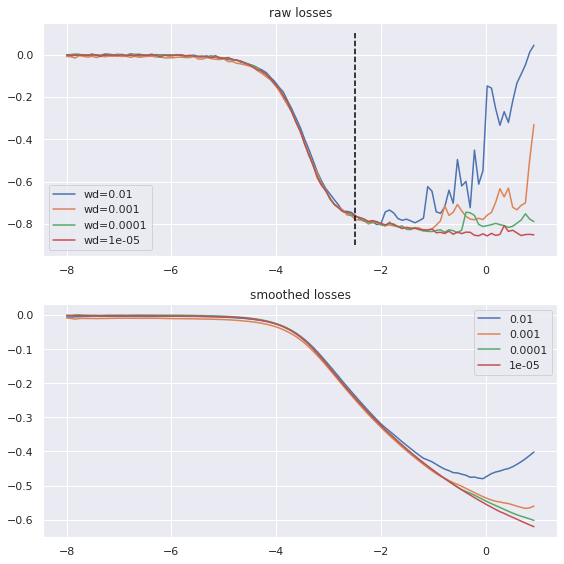

In [17]:
figsize(8, 8)

plt.subplot(2, 1, 1)
for weight_decay in weight_decays:
    plt.plot(res[weight_decay]['log lrs'], 
             res[weight_decay]['raw losses'],
             label=f'wd={weight_decay}')
plt.vlines(-2.5, -0.9, 0.1, linestyles='--', colors='black')
plt.legend()
plt.title('raw losses')

plt.subplot(2, 1, 2)
for weight_decay in weight_decays:
    plt.plot(res[weight_decay]['log lrs'], 
             res[weight_decay]['smoothed losses'],
             label=weight_decay)
plt.legend()
plt.title('smoothed losses')

plt.tight_layout()

### Train

In [18]:
def train_model(train_loader, model, optimizer, scheduler):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr, lrs

In [19]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [20]:
net = Net()
max_lr = 0.005
weight_decay = 0.001 
epochs = 20

optimizer = optim.Adam(net.parameters(),
                       weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=max_lr,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs)

In [21]:
%%time
train_corrs = []
val_corrs = []
best_val_corr = 0.0
best_epoch = 0
num_epochs_run = 0
lrs = []

for epoch in range(epochs):
    num_epochs_run += 1
    
    # train
    print('epoch', epoch)
    train_corr, epoch_lrs = train_model(train_loader, net, optimizer, scheduler)
    train_corr = float(train_corr.detach().numpy())
    train_corrs.append(train_corr)
    lrs.append(epoch_lrs)
    print(f'train corr: {train_corr:.4f}')
    
    # val
    val_corr = model_eval(net, val_loader)
    val_corr = float(val_corr.detach().numpy())
    val_corrs.append(val_corr)
    print(f'val corr: {val_corr:.4f}')
    print()

epoch 0
train corr: 0.7372
val corr: 0.8626

epoch 1
train corr: 0.8786
val corr: 0.8779

epoch 2
train corr: 0.8822
val corr: 0.8786

epoch 3
train corr: 0.8774
val corr: 0.8720

epoch 4
train corr: 0.8738
val corr: 0.8713

epoch 5
train corr: 0.8729
val corr: 0.8729

epoch 6
train corr: 0.8748
val corr: 0.8682

epoch 7
train corr: 0.8765
val corr: 0.8760

epoch 8
train corr: 0.8783
val corr: 0.8776

epoch 9
train corr: 0.8804
val corr: 0.8796

epoch 10
train corr: 0.8821
val corr: 0.8813

epoch 11
train corr: 0.8841
val corr: 0.8837

epoch 12
train corr: 0.8861
val corr: 0.8864

epoch 13
train corr: 0.8876
val corr: 0.8879

epoch 14
train corr: 0.8898
val corr: 0.8886

epoch 15
train corr: 0.8920
val corr: 0.8911

epoch 16
train corr: 0.8945
val corr: 0.8920

epoch 17
train corr: 0.8969
val corr: 0.8929

epoch 18
train corr: 0.8991
val corr: 0.8936

epoch 19
train corr: 0.9004
val corr: 0.8935

CPU times: user 5min 52s, sys: 1.79 s, total: 5min 54s
Wall time: 2min 57s


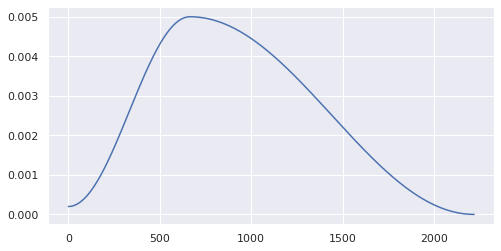

In [22]:
figsize(8, 4)
plt.plot(list(itertools.chain(*lrs)))

(0.7, 1.0)

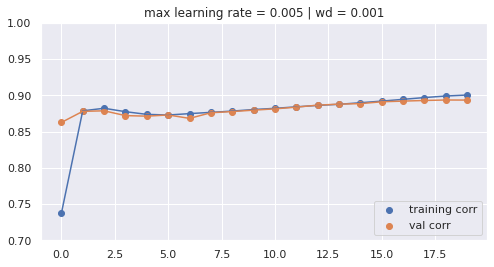

In [23]:
figsize(8, 4)
plt.scatter(list(range(epochs)), train_corrs, label='training corr')
plt.plot(list(range(epochs)), train_corrs)
plt.scatter(list(range(epochs)), val_corrs, label='val corr')
plt.plot(list(range(epochs)), val_corrs)
plt.legend(loc='lower right')
plt.title(f'max learning rate = {max_lr} | wd = {weight_decay}')
plt.ylim(0.7, 1)

In [24]:
del train_inp, train_tar, full_ds
gc.collect()

3575

## Prediction

In [25]:
%%time
test_inp = load_pickle(f'{DATA_DIR}/test_inp')
test_inp = torch.from_numpy(test_inp)

CPU times: user 64.6 ms, sys: 258 ms, total: 322 ms
Wall time: 1.74 s


In [26]:
test_inp = test_inp[:, :-7]

In [27]:
with torch.no_grad():
    net.eval()
    test_tar_preds = net(test_inp).detach().numpy()

In [28]:
del test_inp
gc.collect()

84

## Creating Submission

In [29]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

total 7.1G
-rw-r--r-- 1 nobody nogroup  25K Oct 25 08:09 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup  25K Oct 25 08:09 __output__.json
-rw-r--r-- 1 nobody nogroup 293K Oct 25 08:09 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Oct 25 08:09 custom.css
-rw-r--r-- 1 nobody nogroup 359M Oct 25 08:09 evaluation_ids.parquet
-rw-r--r-- 1 nobody nogroup 3.8M Oct 25 08:09 metadata.parquet
-rw-r--r-- 1 nobody nogroup 108K Oct 25 08:09 metadata_cite_day_2_donor_27678.parquet
-rw-r--r-- 1 nobody nogroup 252M Oct 25 08:09 sample_submission.parquet
-rw-r--r-- 1 nobody nogroup 856K Oct 25 08:09 test_cite_inputs_day_2_donor_27678_idx.npz
-rw-r--r-- 1 nobody nogroup  78M Oct 25 08:09 test_cite_inputs_day_2_donor_27678_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 1.8M Oct 25 08:09 test_cite_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 488M Oct 25 08:09 test_cite_inputs_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 8.4M Oct 25 08:09 test_multi_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 1.7G Oct 25 08:09 

In [30]:
test_tar_cols = np.load(f'{DATA_DIR}/train_cite_targets_idx.npz',
                        allow_pickle=True)['columns']
test_tar_idx = np.load(f'{DATA_DIR}/test_cite_inputs_idx.npz',
                       allow_pickle=True)['index']
test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

((140,), (48663,), (48663, 140))

In [31]:
%%time
print('Start Eval...')
eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

Start Eval...
CPU times: user 29.7 s, sys: 10.2 s, total: 39.9 s
Wall time: 34.6 s


In [32]:
%%time
sub = pd.Series(name='target',
                index=pd.MultiIndex.from_frame(eval_ids), 
                dtype=np.float32)
sub

CPU times: user 19.2 s, sys: 3.72 s, total: 22.9 s
Wall time: 22.9 s


row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [33]:
cell_id_dict = {cell_id: idx 
                for idx, cell_id in enumerate(test_tar_idx, 0)}
gene_id_dict = {gene_id: idx 
                for idx, gene_id in enumerate(test_tar_cols, 0)}

In [34]:
eid_cid_idx = eval_ids['cell_id']\
              .apply(lambda x: cell_id_dict.get(x, -1))
eid_gid_idx = eval_ids['gene_id']\
              .apply(lambda x: gene_id_dict.get(x, -1))
valid_cite_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [35]:
%%time
sub.iloc[valid_cite_rows] = test_tar_preds\
                             [eid_cid_idx[valid_cite_rows].to_numpy(),
                              eid_gid_idx[valid_cite_rows].to_numpy()]

CPU times: user 323 ms, sys: 152 ms, total: 474 ms
Wall time: 475 ms


In [36]:
del eval_ids, test_tar_idx, test_tar_cols
del eid_cid_idx, eid_gid_idx, valid_cite_rows
gc.collect() 

97

In [37]:
sub = pd.DataFrame(sub).fillna(0).reset_index()
sub.drop(['cell_id', 'gene_id'], axis=1)\
   .to_csv('cite_sub.csv', index=False)

In [38]:
sub.head()

,row_id,cell_id,gene_id,target
0,0,c2150f55becb,CD86,-0.011194
1,1,c2150f55becb,CD274,-0.009213
2,2,c2150f55becb,CD270,-0.006905
3,3,c2150f55becb,CD155,0.022184
4,4,c2150f55becb,CD112,0.032435
